In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
import seaborn as sns
import re
import emoji
from emoji import UNICODE_EMOJI
from collections import defaultdict
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import numpy as np
# nltk.download('wordnet')
# import nltk
# nltk.download('punkt')
# nltk.download("stopwords")

In [898]:
df1 = pd.read_csv("hsjain_csv1.csv")
df1 = df1.drop("Notes", axis=1)

In [900]:
cm = confusion_matrix(list(df1.Label_A), list(df1.Label_T), labels=["appreciation", "informative", "other", "rant"])
print(cm)

[[28  8 12  2]
 [10 30 10  5]
 [ 3  8 50 10]
 [ 5  8 13 48]]


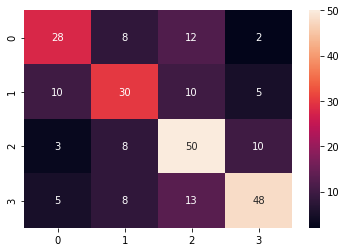

In [901]:
sns.heatmap(cm, annot=True)

In [902]:
def tokenize(text):
    text = text.lower()
    lst = word_tokenize(text)
    
    punctuation = ['(', ')', '?', ':', ';', ',', '.', '!', '/', '"', "'", '@', '’']

    for i in range(len(lst)):
        if lst[i] in punctuation:
            lst[i] = lst[i].replace(lst[i], "")
            
    #for emojis stacked up together
    for word in lst:
        if word.isalnum() == False:
            lst.remove(word)
            helper = emoji.get_emoji_regexp().split(word)
            for h in helper:
                if h != '':
                    lst.append(h)
                    
    #to take care of words with weird non-alnum characters between 2 words. For eg is…I’m
    for word in lst:
        if word.isalnum() == False and word not in UNICODE_EMOJI['en']:
            lst.remove(word)
            s = re.sub(r'[^a-zA-Z0-9]', ' ', word)
            ls = s.split(" ")
            for l in ls:
                lst.append(l)
            
    #Getting rid of extra ""
    while "" in lst:
        lst.remove("")
        
    #Normalization
    for i in range(len(lst)):
        if lst[i].isalpha():
            lst[i] = stemmer.stem(lst[i])
    return lst

In [948]:
vectorizer = CountVectorizer(stop_words = stopwords, ngram_range = (1,1), tokenizer = tokenize)
X = vectorizer.fit_transform(df1.Text)
Y = df1.Label

In [944]:
clf = LogisticRegression().fit(X, Y)

In [945]:
clf.score(X, Y)

0.996

In [981]:
accuracy = precision = recall = 0
cv = KFold(n_splits=10)
count = 0
incorrect = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    for i in range(len(y_test)):
        if count == 10:
            break
        elif y_pred[i] != y_test.iloc[i]:
            count += 1
            incorrect.append((df1.Text.iloc[test_index[i]], y_test.iloc[i], y_pred[i]))           
    
    y_pred = clf.predict(X_test)
    accuracy += accuracy_score(y_test, y_pred)
    precision += precision_score(y_test, y_pred, average=None)
    recall += recall_score(y_test, y_pred, average=None)
    
dataframe = pd.DataFrame(incorrect, columns = ['Tweet', 'Actual', 'Predicted'])
print("Incorrectly classified Samples:")
display(dataframe)

C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Incorrectly classified Samples:


,Tweet,Actual,Predicted
0,Thank you everyone who joined the stream today...,appreciation,other
1,Summer in the Netherlands:\n\nRain\nRain\nRain...,rant,other
2,so the nct not showering thing was true,informative,rant
3,zain acting gay on the tl then getting mad whe...,rant,other
4,Sara Jacobs is good you guys,appreciation,rant
5,I’m the moisture master.,appreciation,other
6,Egyptian cotton for who when there’s presles 😂😂,informative,other
7,Can i have at least one track in their cb albu...,appreciation,other
8,Demons are just angels with their backs turned,informative,other
9,Now why she in it?,rant,other


In [982]:
accuracy/10

0.352

In [983]:
precision/10

array([0.21666667, 0.28666667, 0.38046492, 0.41501082])

In [984]:
recall/10

array([0.07261905, 0.0902381 , 0.73257937, 0.36711039])

In [985]:
weights = clf.coef_

In [986]:
answer = []
top_10 = []
for i in range(len(weights)):
    answer.append(sorted(range(len(weights[i])), key=lambda j: weights[i][j], reverse=True)[:10])

for ans in answer:
    lsttt = []
    for index in ans:
        lsttt.append(vectorizer.get_feature_names()[index])
    top_10.append(lsttt)

column_names = np.unique(df1['Label'])
df = pd.DataFrame(columns = column_names)
count = 0
for top in top_10:
    df[df.columns[count]] = top
    count += 1
df

,appreciation,informative,other,rant
0,cute,angel,last,wtf
1,good,month,tri,whi
2,thank,make,lover,liter
3,ever,ask,mayb,year
4,✨,halloween,complet,everi
5,😍,mind,asw,fav
6,goodmorn,know,emoji,keep
7,amaz,question,fact,😭
8,happi,captain,lloooolllllllll,em
9,god,drew,louder,honest
